# Enrollment

This notebook collects enrollment data on courses of interest from Berkeley's [course catalog](http://classes.berkeley.edu/) and then performs some analysis of that data.

## Collecting the data
If anyone hears of an API for the course catalog, we should use that. Otherwise, we scrape. Each course has its own page on the catalog. Take the URL of the page of each course that you're interested in (e.g. `http://classes.berkeley.edu/content/2017-spring-info-290-006-lec-006`) and put it on its own line in a file called _urls.txt_. The notebook will scrape all the URLs, extract enrollment information and save it.

All the data relevant to enrollments (and other interesting attributes of the course) are stored in four JSON objects called _data-json_, _data-enrollment_, _data-term-details_ and _data-node_ in the HTML of each page. So once we've found those four, it's just a matter of selecting the information that you want from them. Unfortunately, the JSON objects for enrollment information don't have the same hierarchy or names for every course and I can't find any documentation on how it's formatted. To get around this, I've just dealt with the range of hierarchies and names that I've come across so far, by branching depending on what keys are in the JSON.

If something breaks in the data collection, it's likely because I've made assumptions about how the structure of the JSON.

In [56]:
%matplotlib inline
import re
import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from bs4 import BeautifulSoup

URLS_FNAME = 'urls.txt'
OUT_FNAME = 'enrollments.txt'

In [57]:
# These functions are where we look through the JSON objects for the data we care about.

def get_course_title(data_json):
    return data_json['class']['course']['title']

def get_course_number(data_json):
    return data_json['id']

def remove_enrollment_status_level(d):
    """
    The data-enrollment JSON sometimes has different hierarchies and names.
    This function is just to help overcome that. This function is only used 
    in `get_enrollment_dict` below.
    """
    if 'enrollmentStatus' in d:
        return d['enrollmentStatus']
    else:
        return d

def get_enrollment_dict(data_enrollment):
    """
    The data-enrollment JSON sometimes has different hierarchies and names.
    This function is just to help overcome that. Returns all relevant enrollment 
    data in a dict.
    """
    if 'available' in data_enrollment:
        return remove_enrollment_status_level(data_enrollment['available'])
    else:
        return remove_enrollment_status_level(data_enrollment)
    
def get_enrolled_count(data_enrollment):
    enrollment_dict = get_enrollment_dict(data_enrollment)
    return enrollment_dict['enrolledCount']

def get_max_enrollment(data_enrollment):
    enrollment_dict = get_enrollment_dict(data_enrollment)
    return enrollment_dict['maxEnroll']

def get_waitlist_count(data_enrollment):
    enrollment_dict = get_enrollment_dict(data_enrollment)
    return enrollment_dict['waitlistedCount']

def get_max_waitlist(data_enrollment):
    enrollment_dict = get_enrollment_dict(data_enrollment)
    return enrollment_dict['maxWaitlist']

def get_enrollment_status(data_enrollment):
    enrollment_dict = get_enrollment_dict(data_enrollment)
    return enrollment_dict['status']['description']

def parse_session(session_string):
    year, semester = session_string.split()
    return int(year), semester
    
def get_session_date(data_term_details):
    return parse_session(data_term_details['sessionDescription'])

def get_department(data_json):
    return data_json['academicOrganization']['description']

def get_course_level(data_json):
    return data_json['course']['academicCareer']['description']

def get_academic_group(data_json):
    return data_json['academicGroup']['formalDescription']

def get_start_date(data_json):
    return data_json['startDate']

def get_end_date(data_json):
    return data_json['endDate']

def get_location(data_json):
    return data_json['meetings'][0]['location']['description']

def get_number_of_units(data_json):
    return data_json['class']['allowedUnits']['forAcademicProgress']

def make_short_course_name(url):
    """Return names like 'Stat 134' from `url`.
    
    These short names are often more useful than the full title.
    Unfortunately, because Data 8 and Data 100 are listed in the 
    Stats/CS departments, they won't appear with their usual names."""
    pattern = r'\d{4}-(?:fall|spring|summer)-(.*?)-(.*?)-.*'
    match = re.search(pattern, url)
    if match:
        dept, num = match.groups()
        return dept + ' ' + num
    return "Couldn't make short course name"

In [58]:
def extract_data_for_one_course(url):
    """Collect desired enrollment data for course listed at `url`.

    Parameters
    ----------
    url: str
        The URL of the course you're interested in.

    Returns
    -------
    dict
        Selected data points of that course.

    """
    # Scrape the data
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    # Find the four JSON objects
    data_div = soup.find_all('div', 'handlebarData theme_is_cc_berkeley')[0]
    data_enrollment = json.loads(data_div['data-enrollment'])
    data_json = json.loads(data_div['data-json'])
    data_term_details = json.loads(data_div['data-term-details'])
    data_node = json.loads(data_div['data-node'])
    
    # Select the data you want from those four JSON objects.
    # The following lines are grouped by logically related data,
    # not which JSON object they come from
    
    # BASIC INFO ON COURSE
    title = get_course_title(data_json)
    course_number = get_course_number(data_json)
    year, semester = get_session_date(data_term_details)
    department = get_department(data_json)
    
    # ENROLLMENT DATA
    enrolled_count = get_enrolled_count(data_enrollment)
    max_enrollment = get_max_enrollment(data_enrollment)
    waitlist_count = get_waitlist_count(data_enrollment)
    max_waitlist = get_max_waitlist(data_enrollment)
    enrollment_status = get_enrollment_status(data_enrollment)
    open_seats = max_enrollment - enrolled_count # Not in the data received, but we can calculate it
    
    # OTHER INFO ON COURSE - YOU MAY NOT CARE ABOUT ANY OF THIS
    # Currently, getting the level and location are known to have bugs
    # for course urls we've tried. This is because of assumptions on
    # the structure of the JSON. Because it's non-essential, I've just
    # commented these out.
    #level = get_course_level(data_json)
    #academic_group = get_academic_group(data_json)
    #start_date = get_start_date(data_json)
    #end_date = get_end_date(data_json)
    #location = get_location(data_json)
    #number_of_units = get_number_of_units(data_json)
    
    # THE TIME THIS DATA WAS COLLECTED
    now = datetime.now().strftime("%Y-%m-%d %H:%M")
    
    # Make short course name
    short_name = make_short_course_name(url)
    
    # Build the result as a dictionary so that when we turn it into a df later,
    # we don't have to specify in two places what the column names are.
    result = {'title': title,
              'course_number': course_number,
              'short_name': short_name,
              'year': year,
              'semester': semester,
              'department': department,
              'enrolled_count': enrolled_count,
              'max_enrollment': max_enrollment,
              'waitlist_count': waitlist_count,
              'max_waitlist': max_waitlist,
              'enrollment_status': enrollment_status,
              'open_seats': open_seats,
              'collected': now}
    
    return result

def extract_data_for_all_courses(urls):
    """Collect desired enrollment data for all courses listed in `urls`.
    
    This function exists to handle any unexpected errors with a single course.

    Parameters
    ----------
    urls: list(str)
        The URLs of the courses you're interested in.

    Returns
    -------
    pd.DataFrame
    
    """
    results = []
    for url in urls:
        try:
            result = extract_data_for_one_course(url)
            results.append(result)
        except:
            print('Something went wrong with {}'.format(url))
    return results

### Main
Here we read in the URLs from _url.txt_, extract all the data we care about, put it in a pandas DataFrame and save the data to a csv file, appending to an existing file if it already exists. If it does already exist, then we don't want to write the header row again.

In [59]:
with open('urls.txt') as f:
    urls = f.read().splitlines()
data = extract_data_for_all_courses(urls)
df = pd.DataFrame(data)
cols = ['title', 'course_number', 'short_name', 'department', 'semester', 'year','enrolled_count', 'max_enrollment', 
        'open_seats', 'waitlist_count', 'max_waitlist', 'enrollment_status', 'collected']
df = df[cols]
need_header = not os.path.exists(OUT_FNAME)
df.to_csv(OUT_FNAME, index=False, mode='a+', header=need_header)

## Analysis

Every time we run the cell above, we collect the current data for the courses, but we don't have the historical data. So we read in the whole csv which has been accumulating all the data every time we scrape it. Then we do some basic analysis of the data.

In [60]:
df = pd.read_csv(OUT_FNAME)
df

,title,course_number,short_name,department,semester,year,enrolled_count,max_enrollment,open_seats,waitlist_count,max_waitlist,enrollment_status,collected
0,Foundations of Data Science,31678,stat c8,Statistics,Spring,2018,1032,1046,14,14,44,Closed,2018-06-04 11:56
1,Principles & Techniques of Data Science,37227,compsci c100,Electrical Eng & Computer Sci,Spring,2018,619,650,31,0,300,Open,2018-06-04 11:56
2,Probability and Mathematical Statistics in Dat...,30832,stat 88,Statistics,Spring,2018,157,159,2,0,15,Open,2018-06-04 11:56
3,Linear Algebra for Data Science,30833,stat 89a,Statistics,Spring,2018,35,50,15,0,10,Open,2018-06-04 11:56
4,Computational Structures in Data Science,41565,compsci 88,Electrical Eng & Computer Sci,Spring,2018,124,200,76,0,100,Open,2018-06-04 11:56
5,Data Science Applications in Geography,33084,geog 88,Geography,Spring,2018,15,30,15,0,6,Open,2018-06-04 11:56
6,Crime and Punishment: Taking the Measure of th...,32891,legalst 88,L&S Legal Studies,Spring,2018,26,30,4,0,10,Open,2018-06-04 11:56
7,Data Science Connector,42347,ls 88,UG Interdisciplinary Studies,Spring,2018,9,32,23,0,15,Open,2018-06-04 11:56
8,Data Science Connector,42348,ls 88,UG Interdisciplinary Studies,Spring,2018,12,32,20,0,15,Open,2018-06-04 11:56
9,Immunotherapy of Cancer: Success and Failures,32863,mcellbi 88,Molecular & Cell Biology,Spring,2018,17,20,3,0,0,Open,2018-06-04 11:56


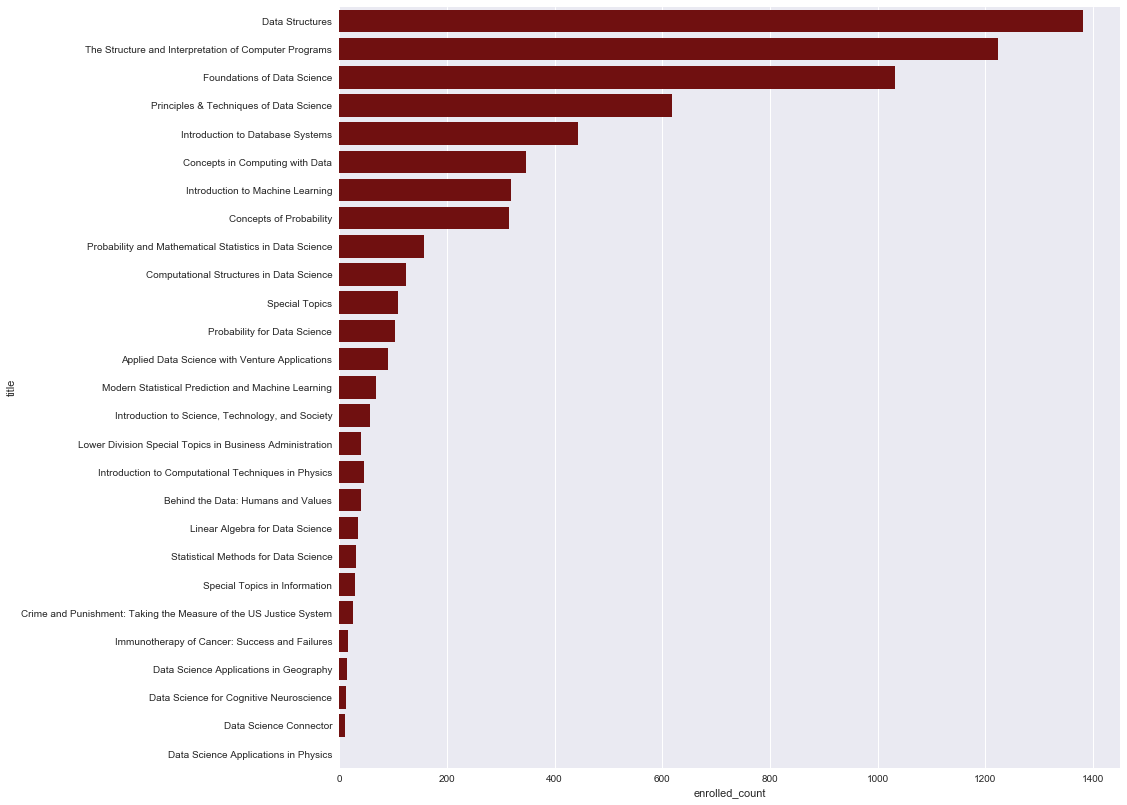

In [61]:
df.sort_values(by='enrolled_count', inplace=True, ascending=False)
plt.figure(figsize=(14, 14))
sns.barplot(x='enrolled_count', y='title', data=df, color='maroon', orient='h', ci=None);

### Output
The script above outputs a single file that stacks all collection dates on top of each other. Users may prefer a single file for each date of collection. The code below filters the dataframe to contain only the data that was collected on the specified date of interest. Just change the year, month and day values in `date_of_interest` and the final line subsets the whole dataframe based on this date.

In [62]:
date_of_interest = datetime.date(datetime(2018, 6, 4))
collected_on_date_of_interest = pd.to_datetime(df['collected']).dt.date == date_of_interest
df[collected_on_date_of_interest]

,title,course_number,short_name,department,semester,year,enrolled_count,max_enrollment,open_seats,waitlist_count,max_waitlist,enrollment_status,collected
23,Data Structures,35432,compsci 61b,Electrical Eng & Computer Sci,Spring,2018,1382,1450,68,0,400,Open,2018-06-04 11:56
22,The Structure and Interpretation of Computer P...,35371,compsci 61a,Electrical Eng & Computer Sci,Spring,2018,1224,1400,176,0,800,Open,2018-06-04 11:56
0,Foundations of Data Science,31678,stat c8,Statistics,Spring,2018,1032,1046,14,14,44,Closed,2018-06-04 11:56
1,Principles & Techniques of Data Science,37227,compsci c100,Electrical Eng & Computer Sci,Spring,2018,619,650,31,0,300,Open,2018-06-04 11:56
24,Introduction to Database Systems,35632,compsci 186,Electrical Eng & Computer Sci,Spring,2018,443,499,56,0,300,Open,2018-06-04 11:56
19,Concepts in Computing with Data,30844,stat 133,Statistics,Spring,2018,347,361,14,0,60,Open,2018-06-04 11:56
18,Introduction to Machine Learning,35661,compsci 189,Electrical Eng & Computer Sci,Spring,2018,319,368,49,0,300,Open,2018-06-04 11:56
20,Concepts of Probability,30856,stat 134,Statistics,Spring,2018,316,396,80,0,60,Open,2018-06-04 11:56
2,Probability and Mathematical Statistics in Dat...,30832,stat 88,Statistics,Spring,2018,157,159,2,0,15,Open,2018-06-04 11:56
4,Computational Structures in Data Science,41565,compsci 88,Electrical Eng & Computer Sci,Spring,2018,124,200,76,0,100,Open,2018-06-04 11:56
